In [1]:
from functions import *
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import cmapy

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Only GPU 1 is visible to this code

# in order to get reproducable results
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)
random.seed(1)

In [2]:
seis_path = '/data/anyu/thebeData/processedThebe/test/oriseis/'
print(seis_path)

/data/anyu/thebeData/processedThebe/test/oriseis/


Make input is IL, Z, XL order.

In [3]:
im_height = 600
im_width = 3174
splitsize = 96
stepsize = 48 #overlap half
overlapsize = splitsize-stepsize

In [4]:
horizontal_splits_number = int(np.ceil((im_width)/stepsize))
print(horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+2*overlapsize
print(width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print(left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height)/stepsize))
print(vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+2*overlapsize
print(height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print(top_pad,bottom_pad)

67
3312
69 69
13
720
60 60


In [5]:
horizontal_splits_number = horizontal_splits_number+1
print(horizontal_splits_number)
vertical_splits_number = vertical_splits_number+1
print(vertical_splits_number)

68
14


In [6]:
halfoverlapsize = int(overlapsize/2)
print(halfoverlapsize)

24


In [7]:
t_start = time.time()
X_list = []
# sectionNumber = 141
# if isval:
#     sectionNumber = 40
# for i in range(0,sectionNumber,1): #len(seis)
i = 20
file_path = seis_path + "{}.npy".format(i)
img = np.load(file_path)[750:1350]
X_list.extend(split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))

print(len(X_list))
print(X_list[0].shape)
print("read images in {} sec".format(time.time()-t_start))
X = np.asarray(X_list)
print(X.shape)
print("read images in {} sec".format(time.time()-t_start))


952
(96, 96)
read images in 0.08057951927185059 sec
(952, 96, 96)
read images in 0.1151273250579834 sec


In [8]:
X = X.astype(np.float32)
# X = np.expand_dims(X,1)
print(X.shape)

(952, 96, 96)


# denoising

In [9]:
dncnnmodelName = "0406_thebe_synthetic_96_96_96"
# dncnnmodelName = "0406_thebe_faultseg_96_96_96"
iterationNo = "8000"
dncnnmodelpath = "/data/cvfault/npt_code/model_zoo/{}/dncnn25/models/{}_G.pth".format(dncnnmodelName,iterationNo)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from network_dncnn import DnCNN as net
# input Thebe to model: Thebe to faultSegclean
model = net()
model.load_state_dict(torch.load(dncnnmodelpath), strict=True)
model.eval()
model = model.to(device)

def single2tensor4(img):
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().unsqueeze(0)
def normalize(img, min_val = 0, max_val = 1):
    return (img - np.min(img)) / (np.max(img) - np.min(img)) * (max_val - min_val) + min_val
def normalize2(img, min_val = 0, max_val = 1):
    return (img - np.min(img)) / (np.max(img) - np.min(img)) * (max_val - min_val) + min_val, np.min(img), np.max(img)

cuda:0


In [10]:
denoised_X = np.zeros_like(X)
print(denoised_X.shape)

(952, 96, 96)


In [11]:
starttime = time.time()
for i in range(len(X)): #len(valnames)
    s = X[i]
    s,smin,smax = normalize2(s, 0, 1)
    if smax != 0 and smin != 0:
        s = np.expand_dims(s, axis=2)  # HxWx1
        s = single2tensor4(s)
        s = s.to(device)
        s = model(s).data.squeeze().float().clamp_(0, 1).cpu().numpy()
        denoised_X[i] = s * (smax - smin) + smin
    print(denoised_X[i].sum(), smin, smax)
#     denoised_X[i] = s
#     normalize(s, smin, smax)
print("time cost: ", time.time()-starttime)

0.0 0.0 0.0
66.2332 -0.22137558 0.12562221
71.06404 -0.34496856 0.26298606
47.67546 -0.34496856 0.29762602
55.144867 -0.31960732 0.29762602
77.81186 -0.31960732 0.22913438
72.987915 -0.38654882 0.33097887
63.637093 -0.94680315 1.0489073
71.55537 -0.94680315 1.0917377
162.88237 -1.4934521 1.3299322
141.79707 -1.4934521 1.3299322
155.78711 -1.435379 1.3680315
110.66314 -1.2487793 1.3680315
63.117065 -1.034606 1.1980772
48.586277 -1.0666637 1.0481071
54.142048 -1.0666637 1.0181246
29.03109 -0.64012706 0.58376324
-21.264585 -0.45076054 0.57170755
-41.752453 -0.40693617 0.57170755
-14.365259 -0.49996984 0.9084329
96.14981 -0.57762116 0.9084329
36.13145 -0.6068602 0.84591854
-49.661415 -0.6068602 0.90262854
-60.17273 -0.663571 0.9073093
-41.197746 -0.663571 0.9242528
-35.723454 -0.72384036 1.0700693
-78.12953 -0.72384036 1.0700693
-83.68049 -0.56010807 0.8386301
63.154152 -0.5235285 0.82384866
175.01752 -0.63148135 1.0049896
120.48694 -0.64435697 1.1915026
12.880096 -0.73606706 1.3318634
-52

49.533123 -0.7269302 0.7381354
-0.32735443 -0.8065878 0.98998207
-13.534241 -0.8065878 1.0008583
55.181427 -0.94130355 1.0461302
99.516914 -1.1619864 1.4466553
160.29404 -1.4512358 1.6210718
115.91575 -1.4512358 1.6210718
67.671486 -1.5520658 1.5326824
52.61951 -1.5520658 1.5813065
88.70834 -1.4888258 1.5813065
14.962048 -1.2810259 1.5726385
17.256147 -1.2190447 1.5106516
17.607407 -1.1209736 1.4034891
-13.144047 -0.9429677 1.388999
-21.356878 -0.9429677 1.3574095
1.3430214 -0.9977568 1.3306389
18.088076 -1.0358257 1.5824699
24.260662 -1.0358257 1.5824699
-70.03048 -1.0230265 1.5125093
-54.623505 -1.045599 1.3359795
-6.060074 -1.0631943 1.1438074
-22.20779 -1.0631943 0.96445924
73.48923 -0.98227584 0.72623706
154.40103 -0.98227584 0.72623706
109.136215 -0.73488057 0.6119552
66.11327 -0.77880037 0.9096074
162.14178 -1.1562786 0.9096074
184.65674 -1.2426138 0.80457044
183.40834 -1.2426138 0.80457044
188.18622 -1.2916622 0.82408166
164.85841 -1.2916622 1.0626345
117.48096 -1.4757605 1.524

11.506197 -0.29649162 0.29584336
26.167316 -0.23761487 0.20102751
38.201218 -0.23761487 0.20102751
34.04242 -0.21232659 0.21126533
31.71302 -0.21232659 0.21516871
39.679558 -0.24429816 0.22066456
55.89235 -0.29398894 0.23917347
111.35095 -0.67113686 0.5839402
99.41907 -0.70574033 0.5839402
97.44058 -0.81795806 0.5561411
67.50635 -0.81795806 0.8093879
74.29262 -0.812153 0.81628263
87.636734 -0.9566779 0.81628263
73.326675 -0.9566779 0.8073619
103.40346 -0.8925151 0.7626932
193.0658 -1.2070026 0.99665576
139.02277 -1.3833399 1.4088364
110.15 -1.3833399 1.4088364
157.58315 -1.1404963 0.8556399
67.375885 -0.5933662 0.54892135
49.915085 -0.5933662 0.5949145
86.19502 -0.7381537 0.7001133
65.687645 -0.7607486 0.814974
81.72342 -0.7607486 0.814974
-22.842377 -0.88610643 1.3837194
-55.299843 -1.1203318 1.5401316
125.65292 -1.1203318 1.5401316
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
26.571274 -0.17665589 0.18778968
23.813232 -0.17665589 0.18778968
20.628721 -0.17730927 0.20770633
33.7144

3.0450335 -0.27287418 0.2363317
18.503254 -0.25078964 0.23879743
36.83278 -0.2480762 0.23879743
30.304142 -0.20210028 0.20248252
27.963032 -0.20274955 0.20054853
32.22532 -0.20274955 0.20054853
13.85708 -0.1734271 0.192918
7.0997005 -0.1734271 0.18102515
23.66182 -0.16241711 0.13879353
32.012623 -0.20045435 0.161511
35.56191 -0.20045435 0.17047149
40.36606 -0.19269139 0.17047149
16.578285 -0.1951921 0.21375972
14.969622 -0.25941658 0.32277244
9.574063 -0.25941658 0.32277244
12.286716 -0.23999077 0.24892235
1.6427755 -0.23860824 0.24892235
2.5029593 -0.23868287 0.25386947
5.2070465 -0.23868287 0.25386947
10.440859 -0.29827946 0.2789805
6.2759705 -0.29827946 0.2789805
23.687704 -0.2756949 0.28506273
41.627045 -0.24126393 0.28506273
44.65601 -0.29341817 0.3030762
38.82464 -0.29341817 0.3030762
58.783188 -0.28339857 0.26743275
49.481728 -0.28128088 0.26615685
66.16496 -0.35327446 0.28476757
70.21634 -0.44173837 0.40123278
70.60641 -0.49576795 0.4763115
72.044365 -0.49576795 0.4763115
0.0 0

In [12]:
print(dncnnmodelName,iterationNo)

0406_thebe_synthetic_96_96_96 8000


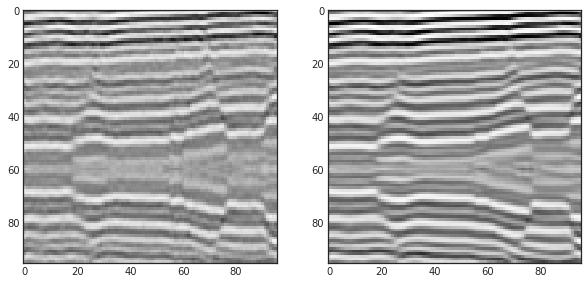

In [13]:
i = 50

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(X[i])
plt.subplot(122)
plt.imshow(denoised_X[i])

In [14]:
WINDOW_SPLINE_2D = window_2D(window_size=splitsize, power=2)
tosave = np.expand_dims(denoised_X,-1)
tosave = np.array([patch * WINDOW_SPLINE_2D for patch in tosave])
tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
recover_Y_test_pred = recover_Image2(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad,overlapsize)
np.save(os.path.join("./","{}_{}denoisedthebe0.npy".format(dncnnmodelName,iterationNo)),np.squeeze(recover_Y_test_pred)[50:550,:])   

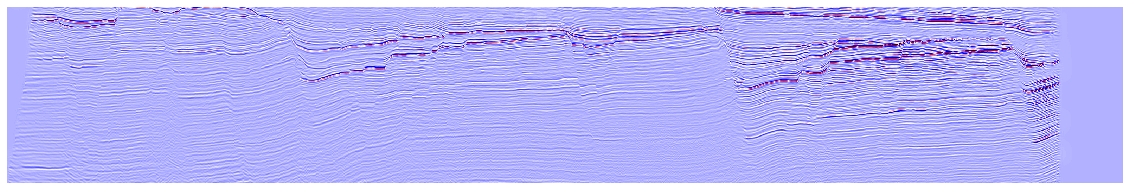

In [15]:
a = np.load("./{}_{}denoisedthebe0.npy".format(dncnnmodelName,iterationNo))
plt.figure(figsize=(20,16))
plt.imshow(a, "seismic")
# plt.colorbar(shrink=0.5)
plt.axis('off')
plt.show()

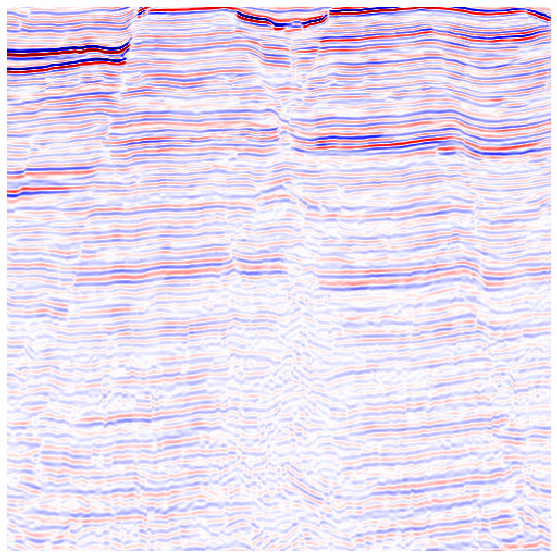

In [16]:
a = np.load("./{}_{}denoisedthebe0.npy".format(dncnnmodelName,iterationNo))
plt.figure(figsize=(10,10))
plt.imshow(a[:,200:700], "seismic")
# plt.colorbar(shrink=0.5)
plt.axis('off')
plt.show()

In [20]:
seis20 = np.load("/data/anyu/thebeData/processedThebe/test/oriseis/" + "20.npy")
denoised = np.load("./0406_thebe_synthetic_96_96_96_8000denoisedthebe0.npy")
transfered = np.load("./0406_thebe_faultseg_96_96_96_8000denoisedthebe0.npy")

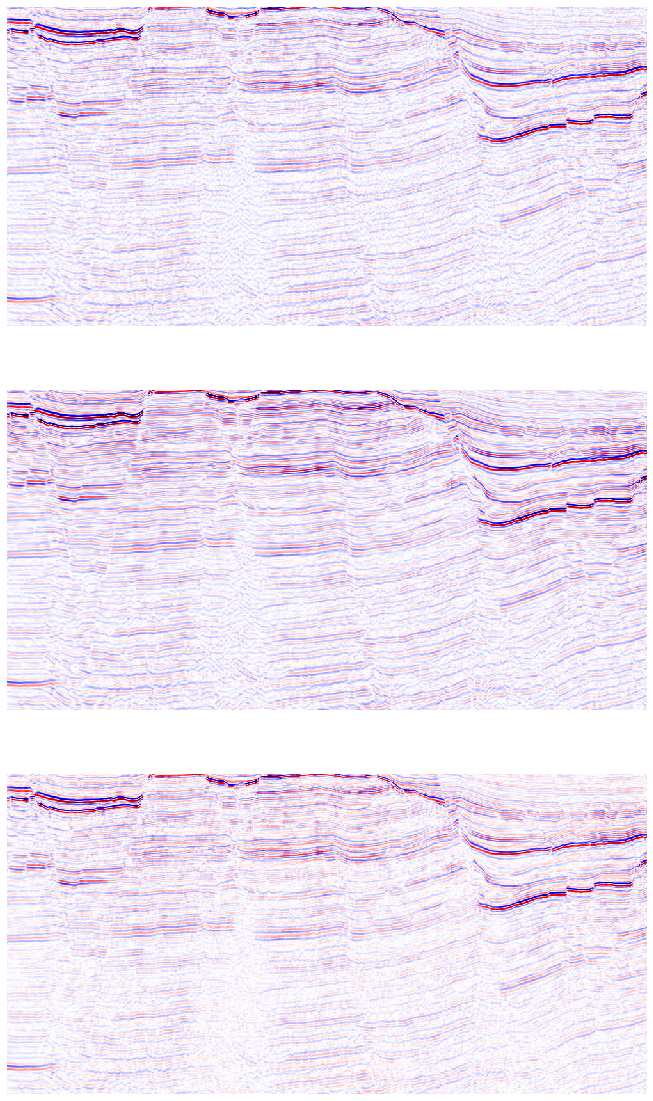

In [28]:
left,right = 100,1100
plt.figure(figsize=(20, 20))
plt.subplot(311)
plt.axis('off')
plt.imshow(seis20[800:1300,left:right],"seismic")
plt.subplot(312)
plt.axis('off')
plt.imshow(denoised[:,left:right],"seismic")
plt.subplot(313)
plt.axis('off')
plt.imshow(transfered[:,left:right],"seismic")

# plt.figure(figsize=(20,16))
# plt.imshow(seis20[800:1300], "seismic")
# # plt.colorbar(shrink=0.5)
# plt.axis('off')
# plt.show()

# unet predict

In [57]:
from models.UNET import Unet
model = Unet()
print("use model Unet")

# modelname = "unetthebe10per_lrp3_p10_lr0.01_b64"
# modelname = "unetthebe10per_0406_thebe_synthetic_96_96_96_8000_lrp3_p10_lr0.01_b64"
modelname = "unetfaultSeg_lrp3_p10_lr0.01_b64"
model.load_state_dict(torch.load("{}.model".format(modelname), map_location="cuda:0")) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model = model.to(device)
model.eval()
print(modelname)

use model Unet
unetfaultSeg_lrp3_p10_lr0.01_b64


In [59]:
import torch.utils.data
class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images):
        self.images = preprocessed_images
#         self.name = name


    def __len__(self):
        return len(self.images)
    
    def transform(self, img):
        # to tensor
        img = TF.to_tensor(img)  
        img = (img-img.min())/(img.max()-img.min())
            
        return img
    

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        return image


# faults_dataset_test = faultsDataset(denoised_X)
faults_dataset_test = faultsDataset(X)

batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [60]:
def saveResults(test_loader):     
    test_predictions = []
    imageNo = -1
    model.eval()
    for images in test_loader:
#         images = Variable(images.double().to(device=device))
        images = Variable(images.to(device=device, dtype=torch.float))
                 
        outputs = model(images)
        y_preds = outputs
#         y_preds = images
        test_predictions.extend(y_preds.detach().cpu())
        if len(test_predictions)>=vertical_splits_number*horizontal_splits_number:
            imageNo = imageNo +1
            tosave = torch.stack(test_predictions).detach().cpu().numpy()[0:vertical_splits_number*horizontal_splits_number]
            test_predictions = test_predictions[vertical_splits_number*horizontal_splits_number:]

            WINDOW_SPLINE_2D = window_2D(window_size=splitsize, power=2)
            tosave = np.moveaxis(tosave,-3,-1)
            tosave = np.array([patch * WINDOW_SPLINE_2D for patch in tosave])
            tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
            recover_Y_test_pred = recover_Image2(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad,overlapsize)
            np.save(os.path.join("./","{}predthebe{}".format(modelname, imageNo)),np.squeeze(recover_Y_test_pred)[50:550,:])   
            print(imageNo)
                        

print("save")
t1 = time.time()
saveResults(test_loader)
t2 = time.time()
print('save in {} sec'.format(t2-t1))

save
0
save in 1.0151448249816895 sec


In [61]:
print(modelname)

unetfaultSeg_lrp3_p10_lr0.01_b64


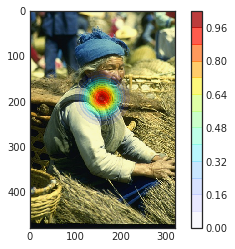

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image

#2D Gaussian function
def twoD_Gaussian(x, y, xo, yo, sigma_x, sigma_y):
    a = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    c = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    g = np.exp( - (a*((x-xo)**2) + c*((y-yo)**2)))
    return g.ravel()


def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap


#Use base cmap to create transparent
mycmap = transparent_cmap(plt.cm.jet)


# Import image and get x and y extents
I = Image.open('./test.jpg')
p = np.asarray(I).astype('float')
w, h = I.size
y, x = np.mgrid[0:h, 0:w]

#Plot image and overlay colormap
fig, ax = plt.subplots(1, 1)
ax.imshow(I)
Gauss = twoD_Gaussian(x, y, .5*x.max(), .4*y.max(), .1*x.max(), .1*y.max())
cb = ax.contourf(x, y, Gauss.reshape(x.shape[0], y.shape[1]), 15, cmap=mycmap)
plt.colorbar(cb)
plt.show()

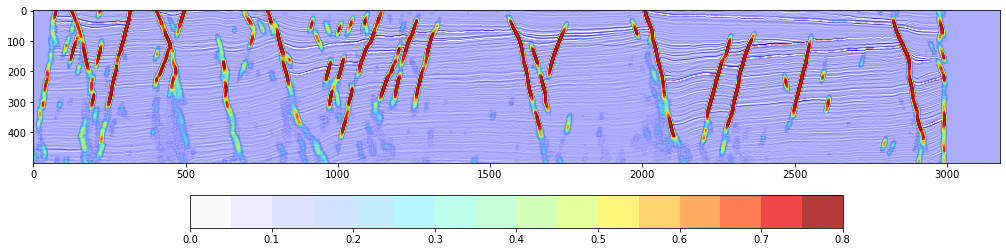

In [24]:

I = seis20[800:1300]
a = np.load("./unetthebe10per_0406_thebe_synthetic_96_96_96_8000_lrp3_p10_lr0.01_b64predthebe0.npy")
fig, ax = plt.subplots(1, 1, figsize = (20,4))
# ax.figure(figsize=(20,16))
ax.imshow(I, "seismic")
h,w = I.shape
y, x = np.mgrid[0:h, 0:w]
cb = ax.contourf(x, y, a, 15, cmap=mycmap)
plt.colorbar(cb,orientation='horizontal')
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap
#Use base cmap to create transparent
mycmap = transparent_cmap(plt.cm.jet)

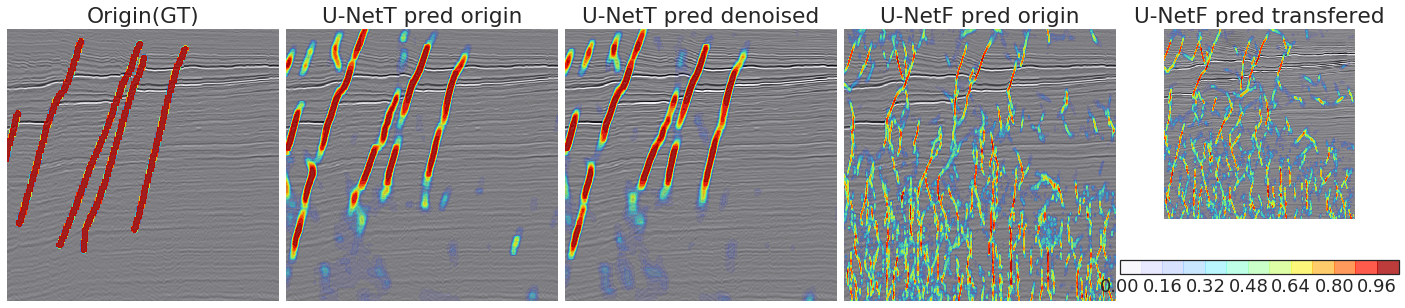

In [9]:
left, right = 1000, 1500
seis20 = np.load("/data/anyu/thebeData/processedThebe/test/oriseis/" + "20.npy")[800:1300,left:right]
fault20 = np.load("/data/anyu/thebeData/processedThebe/test/annotation" + "/20.npy")[800:1300,left:right]

unetT_pred_ori = np.load("./unetthebe10per_lrp3_p10_lr0.01_b64predthebe0.npy")[:,left:right]
denoised = np.load("./0406_thebe_synthetic_96_96_96_8000denoisedthebe0.npy")[:,left:right]
unetT_pred_denoise = np.load("./unetthebe10per_0406_thebe_synthetic_96_96_96_8000_lrp3_p10_lr0.01_b64predthebe0.npy")[:,left:right]

unetF_pred_ori = np.load("./unetfaultSeg_lrp3_p10_lr0.01_b64predthebe0.npy")[:,left:right]
transfered = np.load("./0406_thebe_faultseg_96_96_96_8000denoisedthebe0.npy")[:,left:right]
unetF_pred_transfered = np.load("./unetfaultSeg_lrp3_p10_lr0.01_b64preddenoisedthebe0.npy")[:,left:right]

h,w = seis20.shape
y, x = np.mgrid[0:h, 0:w]


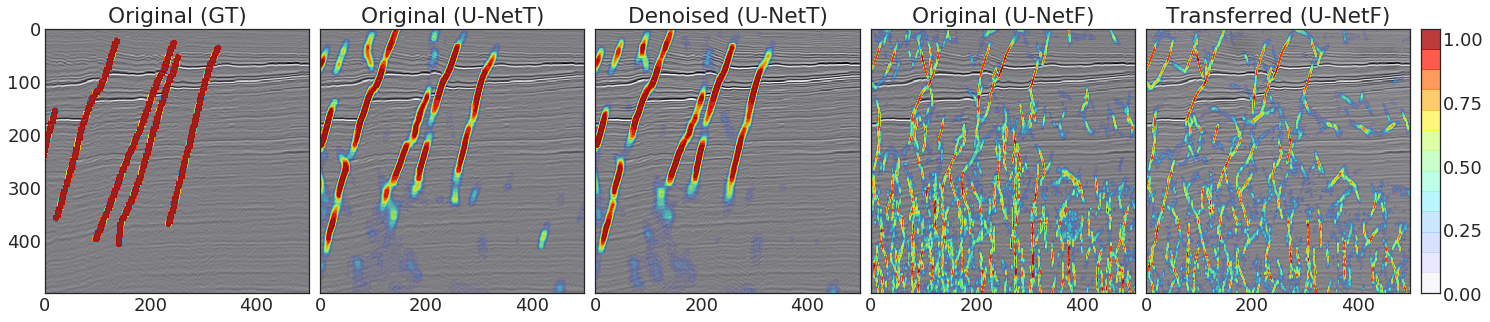

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(25,5))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,5),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
# print(grid)
# Add data to image grid
# for ax in grid:
#     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)


grid[0].set_title('Original (GT)')
grid[1].set_title('Original (U-NetT)')
grid[2].set_title('Denoised (U-NetT)')
grid[3].set_title('Original (U-NetF)')
grid[4].set_title('Transferred (U-NetF)')

grid[0].imshow(seis20, cmap='gray')
grid[0].contourf(x, y, fault20, 15, cmap=mycmap)
grid[1].imshow(seis20, cmap='gray')
grid[1].contourf(x, y, unetT_pred_ori, 15, cmap=mycmap)
grid[2].imshow(denoised, cmap='gray')
grid[2].contourf(x, y, unetT_pred_denoise, 15, cmap=mycmap)
grid[3].imshow(seis20, cmap='gray')
grid[3].contourf(x, y, unetF_pred_ori, 15, cmap=mycmap)
grid[4].imshow(transfered, cmap='gray')
cb = grid[4].contourf(x, y, unetF_pred_transfered, 15, cmap=mycmap)

# # Colorbar
grid[4].cax.colorbar(cb)
grid[4].cax.toggle_label(True)
grid[4].cax.annotate("", xy=(0.5, 0.5), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->"))

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
# plt.show()
plt.savefig("fault_thebe_large500500.png", dpi=300, bbox_inches='tight')